## Стратификация

In [11]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns


from scipy.stats import ttest_ind
from scipy.stats import shapiro

__Теперь, когда у нас есть некоторое представление, чем занимается AB - тестирование, сформулируем более детальный алгоритм__:
1. Определить целевую метрику
2. Сформулировать статистическую гипотезу и критерий её проверки
3. Зафиксировать минимальный ожидаемый эффект и допустимые вероятности ошибок I и II рода
4. Оценить необходимый размер групп
5. Сформировать экспериментальную и контрольную группы
6. Провести эксперимент
7. Оценить результаты эксперимента

In [24]:
samples1 = np.random.exponential(1, size=100)
samples2 = np.random.exponential(1.01, size=100)

In [18]:
means = []
for i in range(10000):
    np.random.shuffle(samples1)
    means.append(samples1[:50].mean())

In [25]:
ttest_ind(samples1, samples2)

Ttest_indResult(statistic=-0.1432262398506546, pvalue=0.8862571608912881)

In [22]:
alpha = 0.05                    # вероятность ошибки 1 рода
beta = 0.2                      # вероятность ошибки 2 рода
mu_control = 2500               # средняя выручка с пользователя в контрольной группе
effect = 100                    # размер эффекта
mu_pilot = mu_control + effect  # средняя выручка с пользователя в экспериментальной группе
std = 800                      # стандартное отклонение

* Рассчитаем неоходимый размер выборки

$n > \dfrac{\left[ \left( F^{-1}(1-\dfrac{\alpha}{2}) + F^{-1}(1-\beta) \right) \right]^2 \cdot \left(\sigma_{x}^2 + \sigma_{y}^2 \right)}{\bigtriangleup^2}$

In [23]:
t_alpha = st.norm.ppf(1 - alpha / 2, loc=0, scale=1)
t_beta = st.norm.ppf(1 - beta, loc=0, scale=1)
var = std ** 2 + std ** 2
sample_size = np.ceil((t_alpha + t_beta) ** 2 * var / (effect ** 2))
print(f'Минимальный объем выборки, чтобы при заданных ошибках 1 и 2 рода наблюдать такое различие = {int(sample_size)} элементов')

Минимальный объем выборки, чтобы при заданных ошибках 1 и 2 рода наблюдать такое различие = 1005 элементов


* Проверим контролирует ли ошибки необходимый объем выборки

In [26]:
first_type_errors = []
second_type_errors = []
 
sample_size = 1005
 
for _ in range(10000): # Проведем 10000 запусков

    control_one = np.random.normal(mu_control, std, sample_size) # Группа1
    control_two = np.random.normal(mu_control, std, sample_size) # Группа2, в случае, если разницы в группах нет
    pilot = np.random.normal(mu_pilot, std, sample_size) # Группа2, в случае, если разница в группах есть
    
    _, pvalue_aa = st.ttest_ind(control_one, control_two) # ttest для групп, в которых разницы нет
    first_type_errors.append(pvalue_aa < alpha) # Проверим, произошла ли ошибка первого рода
    
    _, pvalue_ab = st.ttest_ind(control_one, pilot) # ttest для групп, в которых разница есть
    second_type_errors.append(pvalue_ab >= alpha) # Проверим, произошла ли ошибка второго рода

part_first_type_errors = np.mean(first_type_errors) # Вычисление ошибки первого рода
part_second_type_errors = np.mean(second_type_errors) # Вычисление ошибки второго рода

print(f'part_first_type_errors = {part_first_type_errors:0.3f}')
print(f'part_second_type_errors = {part_second_type_errors:0.3f}')

part_first_type_errors = 0.051
part_second_type_errors = 0.199


* Отлично, ошибки на данном кол-ве элементов контролируется!

* Для примера, что же произойдет, если выборка будет меньше, например 100

In [32]:
first_type_errors = []
second_type_errors = []
 
sample_size = 100
 
for _ in range(10000): # Проведем 10000 запусков

    control_one = np.random.normal(mu_control, std, sample_size) # Группа1
    control_two = np.random.normal(mu_control, std, sample_size) # Группа2, в случае, если разницы в группах нет
    pilot = np.random.normal(mu_pilot, std, sample_size) # Группа2, в случае, если разница в группах есть
    
    _, pvalue_aa = st.ttest_ind(control_one, control_two) # ttest для групп, в которых разницы нет
    first_type_errors.append(pvalue_aa < alpha) # Проверим, произошла ли ошибка первого рода
    
    _, pvalue_ab = st.ttest_ind(control_one, pilot) # ttest для групп, в которых разница есть
    second_type_errors.append(pvalue_ab >= alpha) # Проверим, произошла ли ошибка второго рода

part_first_type_errors = np.mean(first_type_errors) # Вычисление ошибки первого рода
part_second_type_errors = np.mean(second_type_errors) # Вычисление ошибки второго рода

print(f'part_first_type_errors = {part_first_type_errors:0.3f}')
print(f'part_second_type_errors = {part_second_type_errors:0.3f}')

part_first_type_errors = 0.050
part_second_type_errors = 0.864


* Очень увеличивается ошибка второго рода, упала мощность, критерий не способен за 100 элементов выборки, фиксировать такие различия

__Возвращаясь к нашей задаче, 1005 элементов даст нам необходимую ошибку 2 рода, но можем ли мы как-то ее еще уменьшить для обнаружения такого эффекта, который мы хотим?__  

___Если у нас есть еще какие-то данные о наших пользователях, которые как-то коррелируют с целевой метрикой, мы можем попробовать применить их для уменьшение ошибки 2 рода!___  

* Немного определений: 

__Ковариата__ - метрика, которая коррелирует с целевой метрикой, может быть измерена до эксперимента (строго говоря, нет) и не зависит от других экспериментов. В нашем случае факт регистрации в программе лояльности до эксперимента будет ковариатой.

С помощью ковариат можно разделить популяцию на непересекающиеся подмножества, которые будут обладать уникальным набором значений ковариат. Такие подмножества будем называть __стратами__.

В нашем примере будет две страты:

* первая - кто не зарегистрирован в программе лояльности;

* вторая - кто зарегистрирован в программе лояльности.

Посмотрим на исторические данные пользователей этих страт по отдельности. Допустим, мы выяснили, следующую информацию:

доли страт в популяции равны и составляют 50%;

средняя выручка за неделю в первой страте равна 2000 рублей, во второй - 3000 рублей;

стандартные отклонения выручки за неделю равны 625 рублей в обеих стратах. При таких значениях отклонений объединение данных обеих страт будет иметь отклонение около 800 рублей, как было изначально.

__Займемся сравнением результатов со стратифицированием и без стратифицирования__ 

<AxesSubplot:ylabel='Count'>

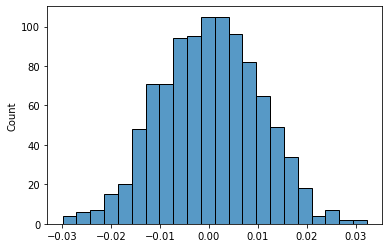

In [48]:
corr_coefs = []
for i in range(1000):
    s1 = np.random.normal(size=10000)
    s2 = np.random.normal(size=10000)

    corr_coefs.append(np.corrcoef(s1, s2)[0, 1])
sns.histplot(corr_coefs)

In [42]:
import pandas as pd

def get_stratified_data(strat_to_param, effect=0):
    """Генерирует данные стратифицированным семплированием.

    Возвращает датафрейм со значениями метрики и страт пользователей
    в контрольной и экспериментальной группах.

    strat_to_param - словарь с параметрами страт
    effect - размер эффекта
    """
    control, pilot = [], []
    for strat, (n, mu, std) in strat_to_param.items(): 
        control += [
            (x, strat) for x in np.random.normal(mu, std, n)
        ]
        pilot += [
            (x, strat) for x in np.random.normal(mu + effect, std, n)
        ]
    columns = ['value', 'strat']
    control_df = pd.DataFrame(control, columns=columns)
    pilot_df = pd.DataFrame(pilot, columns=columns)
    return control_df, pilot_df
 
 
def get_random_data(strats, sample_size, strat_to_param, effect=0):
    """Генерирует данные случайным семплированием.

    Возвращает датафрейм со значениями метрики и страт пользователей
    в контрольной и экспериментальной группах.

    strats - cписок страт в популяции
    sample_size - размеры групп
    strat_to_param - словарь с параметрами страт
    effect - размер эффекта
    """
    control_strats, pilot_strats = np.random.choice(
        strats, (2, sample_size), False
    )
    control, pilot = [], []
    for strat, (n, mu, std) in strat_to_param.items():
        n_control_ = np.sum(control_strats == strat)
        control += [
            (x, strat) for x in np.random.normal(mu, std, n_control_)
        ]
        n_pilot_ = np.sum(pilot_strats == strat)
        pilot += [
            (x, strat) for x in np.random.normal(mu + effect, std, n_pilot_)
        ]
    columns = ['value', 'strat']
    control_df = pd.DataFrame(control, columns=columns)
    pilot_df = pd.DataFrame(pilot, columns=columns)
    return control_df, pilot_df


def ttest(a: pd.DataFrame, b: pd.DataFrame) -> float:
    """Возвращает pvalue теста Стьюдента.
  
    a, b - данные пользователей контрольной и экспериментальной групп
    """
    _, pvalue = st.ttest_ind(a['value'].values, b['value'].values)
    return pvalue

* Сравним вероятность ошибок первого рода, для этого нам необходим А/А - тест

__Сравнение AA-тестов__

In [44]:
alpha = 0.05                        # уровень значимости
N = 10000                           # количество пользователей в популяции
w_one, w_two = 0.5, 0.5             # доли страт в популяции
N_one = int(N * w_one)              # количество пользователей первой страты
N_two = int(N * w_two)              # количество пользователей второй страты
mu_one, mu_two = 2000, 3000         # средние выручки в стратах
std_one, std_two = 625, 625         # стандартное отклонение в стратах

# список страт в популяции
strats = [1 for _ in range(N_one)] + [2 for _ in range(N_two)] # Задаем номер страты

# размер групп эксперимента
sample_size = 1006  # В каждой группе будет по 1006 участников
sample_size_one = int(sample_size * w_one) # количество пользователей первой страты в каждой из контрольной и экспериментальной групп
sample_size_two = int(sample_size * w_two) # количество пользователей второй страты в каждой из контрольной и экспериментальной групп

# Словарь, который ключем которой является страта, а значением словаря являются параметры распределения
strat_to_param = {
    1: (sample_size_one, mu_one, std_one,),
    2: (sample_size_two, mu_two, std_two,)
}

random_first_type_errors = [] # Здесь будет мониторинг ошибки первого рода без стратифицирования. 
stratified_first_type_errors = [] # Здесь будет мониторинг ошибки первого рода со стратифицирования.

random_deltas = []
stratified_deltas = []

for _ in range(10000): # Генерация 10000 выборок, чтобы эмпирически вычислить нашу ошибку первого рода
    
    # control_random - контрольная группа, разбиение идет случайным, не обращая внимания на страты
    # pilot_random - экспериментальная группа, разбиение идет случайным, не обращая внимания на страты
    control_random, pilot_random = get_random_data( 
        strats, sample_size, strat_to_param
    )
    
    # control_stratified_random - контрольная группа, в ней половина элементов первой страты, половина второй
    # pilot_stratified_random - экспериментальная группа, в ней половина элементов первой страты, половина второй
    control_stratified, pilot_stratified = get_stratified_data(
        strat_to_param
    )
    random_deltas.append(
        pilot_random['value'].mean() - control_random['value'].mean()
    )
    stratified_deltas.append(
        pilot_stratified['value'].mean() - control_stratified['value'].mean()
    )

    pvalue_random = ttest(control_random, pilot_random)
    random_first_type_errors.append(pvalue_random < alpha)
    pvalue_stratified = ttest(control_stratified, pilot_stratified)
    stratified_first_type_errors.append(pvalue_stratified < alpha)
 
part_random_first_type_errors = np.mean(random_first_type_errors)
part_stratified_first_type_errors = np.mean(stratified_first_type_errors)
print(f'part_random_first_type_errors = {part_random_first_type_errors:0.3f}')
print(f'part_stratified_first_type_errors = {part_stratified_first_type_errors:0.3f}')

part_random_first_type_errors = 0.050
part_stratified_first_type_errors = 0.011


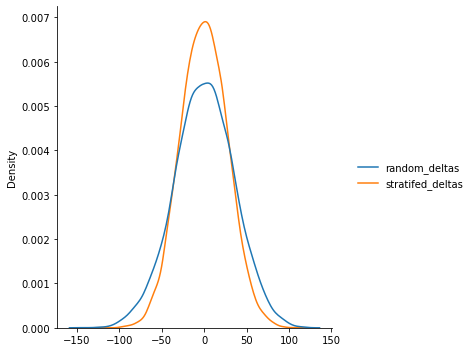

In [45]:
sns.displot(
    {'random_deltas': random_deltas, 'stratifed_deltas': stratified_deltas},
    kind='kde'
);

Глядя на графики, почему уменьшилась ошибка 1 рода?

__При стратифицированном семплированиии ошибка первого рода упала примерно в 4 раза__

__Сравнение AB-тестов__

In [49]:
effect = 100 # Размер эффекта, который мы хотим наблюдать
random_second_type_errors = []
stratified_second_type_errors = []

for _ in range(10000): # Генерация 10000 выборок, чтобы эмпирически вычислить нашу ошибку второго рода
    
    # control_random - контрольная группа, разбиение идет случайным, не обращая внимания на страты
    # pilot_random - экспериментальная группа, разбиение идет случайным, не обращая внимания на страты    
    control_random, pilot_random = get_random_data(
        strats, sample_size, strat_to_param, effect
    )
    
    # control_stratified_random - контрольная группа, в ней половина элементов первой страты, половина второй
    # pilot_stratified_random - экспериментальная группа, в ней половина элементов первой страты, половина второй
    control_stratified, pilot_stratified = get_stratified_data(
        strat_to_param, effect
    )
    pvalue_random = ttest(control_random, pilot_random)
    random_second_type_errors.append(pvalue_random >= alpha)
    pvalue_stratified = ttest(control_stratified, pilot_stratified)
    stratified_second_type_errors.append(pvalue_stratified >= alpha)
 
part_random_second_type_errors = np.mean(random_second_type_errors)
part_stratified_second_type_errors = np.mean(stratified_second_type_errors)
print(f'part_random_second_type_errors = {part_random_second_type_errors:0.3f}')
print(f'part_stratified_second_type_errors = {part_stratified_second_type_errors:0.3f}')

part_random_second_type_errors = 0.201
part_stratified_second_type_errors = 0.138


__Ошибка второго рода так же упала, а значит выросла мощность критерия!__

* Когда происходит дизайн AB-теста, мы фиксируем уровень значимости - это наша готовность ложно найти различия в группах, там где их нет
* У нас изначально наш уровень значимости $\alpha = 0.5$
* При стратифицирование наша $\alpha$ упала, а значит поднялась $\beta$ и упала мощность(1 - $\beta$)
* Чтобы создать наиболее мощный критерий, мы должны вернуть ошибку $\alpha$ на исходный уровень
*  Так происходит из-за того, что при стратифицированном семплировании мы не только делаем распределение средних более узким, но и снижаем дисперсию, зафиксировав количество страт в каждой группе. 
* Тест Стьюдента не знает о том, что мы семплируем данные не случайно, поэтому при подсчёте статистики используется завышенная оценка дисперсии. Вернуть тест на нужный уровень значимости нам поможет стратифицированное среднее.


* Ранее мы среднее в группах вычисляли по формуле:  
$\overline{Y} = \dfrac{1}{n}\sum_{k=1}^{K}\sum_{j=1}^{n_k}Y_{kj}$, $k$ - номер страты, $j$ - номер элемента в страте

* Теперь будем вычситывать взвешенное среднее(стратифицированное среднее)  
$\overline{Y_{strat}} = \sum_{k=1}^{K}\omega_{k} * \overline{Y_{k}}$, где $\overline{Y_k} = \dfrac{1}{n_{k}}\sum_{j=1}^{n_{k}}Y_{kj}$, $\omega_{k}$ - доля элементов из k-ой страты

In [54]:
def calc_strat_mean(df: pd.DataFrame, weights: pd.Series) -> float:
    """Считает стратифицированное среднее.

    df - датафрейм с целевой метрикой и данными для стратификации
    weights - маппинг {название страты: вес страты в популяции}
    """
    strat_mean = df.groupby('strat')['value'].mean()
    return (strat_mean * weights).sum()


def calc_strat_var(df: pd.DataFrame, weights: pd.Series) -> float:
    """Считает стратифицированную дисперсию.
    df - датафрейм с целевой метрикой и данными для стратификации
    weights - маппинг {название страты: вес страты в популяции}
    """
    strat_var = df.groupby('strat')['value'].var()
    return (strat_var * weights).sum()


def ttest_strat(a: pd.DataFrame, b: pd.DataFrame, weights: pd.Series) -> float:
    """Возвращает pvalue теста Стьюдента для стратифицированного среднего.

    a, b - данные пользователей контрольной и экспериментальной групп
    weights - маппинг {название страты: вес страты в популяции}
    """
    a_strat_mean = calc_strat_mean(a, weights)
    b_strat_mean = calc_strat_mean(b, weights)
    a_strat_var = calc_strat_var(a, weights)
    b_strat_var = calc_strat_var(b, weights)
    delta = b_strat_mean - a_strat_mean
    std = (a_strat_var / len(a) + b_strat_var / len(b)) ** 0.5
    t = delta / std
    pvalue = 2 * (1 -  st.norm.cdf(np.abs(t)))
    return pvalue


weights = pd.Series({1: w_one, 2: w_two})

first_type_errors = []
second_type_errors = []

for _ in range(10000):
    control_aa, pilot_aa = get_stratified_data(
        strat_to_param
    )
    control_ab, pilot_ab = get_stratified_data(
        strat_to_param, effect
    )

    pvalue_aa = ttest_strat(control_aa, pilot_aa, weights)
    first_type_errors.append(pvalue_aa < alpha)
    pvalue_ab = ttest_strat(control_ab, pilot_ab, weights)
    second_type_errors.append(pvalue_ab >= alpha)


part_first_type_errors = np.mean(first_type_errors)
part_second_type_errors = np.mean(second_type_errors)
print(f'part_first_type_errors = {part_first_type_errors:0.3f}')
print(f'part_second_type_errors = {part_second_type_errors:0.3f}')

part_first_type_errors = 0.049
part_second_type_errors = 0.047


##### было
part_stratified_first_type_errors = 0.011  
part_stratified_second_type_errors = 0.138

##### стало
part_first_type_errors = 0.049  
part_second_type_errors = 0.047